# Converting a Pulser sequence into a Job

In [3]:
import numpy as np
from qat.core import Schedule, Variable
from qat.core.variables import heaviside

Simulation on Pasqal hardware can be performed using [Pulser](https://pulser.readthedocs.io/). This notebook presents how to convert a Pulser `Sequence` into a `Schedule` or a `Job` that can be executed on MyQLM. 

## Defining Pulser's AQPU

In [4]:
from pulser import Pulse, Sequence, Register
from pulser.waveforms import CustomWaveform
from pulser.devices import MockDevice
from pulser_myqlm import IsingAQPU
from pulser_myqlm.myqlmtools import are_equivalent_schedules

On Pulser, any simulation starts by defining a `Device` and a `Register`. Any `PulserAQPU` should be defined by these two objects, or by a sequence directly.

`IsingAQPU` describes a specific AQPU on which only pulses applied on a `Rydberg.Global` channel can be run. This generates Ising Hamiltonians defined by the `Register` and the pulses sent (see next section).

Let's start by creating a device having a `Rydberg.Global` channel, and a square register of 2x2 atoms spaced by $4\mu m$. The `MockDevice` defines a device for simulations on which all channels are implemented.



In [5]:
device = MockDevice
register = Register.square(2, 4, None)
qpu = IsingAQPU(device, register)

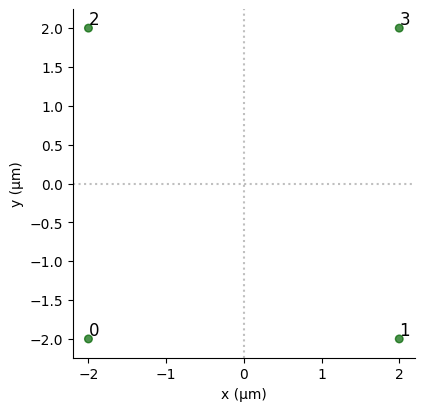

In [6]:
# You can see the register used by the qpu
qpu.register.draw()

In [7]:
# Check qpu properties
print(
    "Distances (in um):\n", qpu.distances, "\n"
)  # symetric matrix, for each qubit two qubits are at 4um distance and one at 4 * sqrt(2) um
print("Interactions (in rad/us):\n", qpu.c6_interactions)  # symetric matrix, C_6/R^6

Distances (in um):
 [[0.         4.         4.         5.65685425]
 [4.         0.         5.65685425 4.        ]
 [4.         5.65685425 0.         4.        ]
 [5.65685425 4.         4.         0.        ]] 

Interactions (in rad/us):
 [[   0.         1323.28089111 1323.28089111  165.41011139]
 [1323.28089111    0.          165.41011139 1323.28089111]
 [1323.28089111  165.41011139    0.         1323.28089111]
 [ 165.41011139 1323.28089111 1323.28089111    0.        ]]


## Defining an Ising Hamiltonian on MyQLM

### The Ising Hamiltonian on Pulser

On Pulser we can solve problems of shape 
$$ H = \hbar \sum_i \frac{\Omega(t)}{2}(\cos(\phi) \sigma_i^x - \sin(\phi) \sigma_i^y) - \frac{\delta(t)}{2}\sigma_i^z + \frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$$
with $\sigma_i^x$, $\sigma_i^y$, $\sigma_i^z$ the Pauli operators $X$, $Y$, $Z$ applied on qubit $i$ and $n_i = \frac{1-\sigma_i^z}{2}$.

This Hamiltonian is named the <u>Ising Hamiltonian</u>. The coefficient $U_{ij}$ is defined by the distance between the atoms $i$ and $j$, that was configured previously with the `Register`. For more information regarding this Hamiltonian, you can have a look to the [Pulser documentation](https://pulser.readthedocs.io/en/stable/review.html).  

It depends on $\Omega$, $\delta$ and $\phi$, that are the amplitude, detuning and phase of a `Pulse` in Pulser. The amplitude and the detuning can be time-dependent, whereas the phase is constant. Let's start by defining time-dependent amplitude and detuning:

In [8]:
t_variable = Variable("t")  # in ns
u_variable = Variable("u")  # parameter
omega_t = t_variable  # in rad/us
delta_t = 1 - t_variable + u_variable  # in rad/us

### Defining an Ising Hamiltonian from an `IsingAQPU`

We can then compute the Ising Hamiltonians associated to pulses defined by $\Omega$, $\delta$, $\phi$ using `IsingAQPU.hamiltonian`.

- Here is an Hamiltonian associated with a pulse of constant amplitude $\Omega=1rad/\mu s$, zero detuning and phase.
It is equivalent to apply a X gate on each qubit, and ZZ gates whose coefficients are defined from the Van der Waals interactions between the atoms.

In [9]:
t1 = 20  # in ns
H1 = qpu.hamiltonian(1, 0, 0)  # omega(t)=1, delta(t)=0, phi=0
print(H1)  # in rad/us

1405.9859468078614 * I^4 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
0.5 * (X|[3]) +
330.8202227783203 * (ZZ|[1, 0]) +
330.8202227783203 * (ZZ|[2, 0]) +
41.35252784729002 * (ZZ|[2, 1]) +
702.9929734039307 * (Z|[0]) +
41.35252784729002 * (ZZ|[3, 0]) +
702.9929734039306 * (Z|[1]) +
330.8202227783203 * (ZZ|[3, 1]) +
702.9929734039306 * (Z|[2]) +
702.9929734039306 * (Z|[3]) +
330.8202227783203 * (ZZ|[3, 2])


- If now the phase is equal to $\pi / 2$, we no longer add a X gate on each qubit but a Y gate.

In [10]:
t2 = 20  # in ns
H2 = qpu.hamiltonian(1, 0, np.pi / 2)  # omega(t)=1, delta(t)=0, phi=pi/2
print(H2)  # in rad/us

1405.9859468078614 * I^4 +
-0.5 * (Y|[0]) +
-0.5 * (Y|[1]) +
-0.5 * (Y|[2]) +
-0.5 * (Y|[3]) +
330.8202227783203 * (ZZ|[1, 0]) +
330.8202227783203 * (ZZ|[2, 0]) +
41.35252784729002 * (ZZ|[2, 1]) +
702.9929734039307 * (Z|[0]) +
41.35252784729002 * (ZZ|[3, 0]) +
702.9929734039306 * (Z|[1]) +
330.8202227783203 * (ZZ|[3, 1]) +
702.9929734039306 * (Z|[2]) +
702.9929734039306 * (Z|[3]) +
330.8202227783203 * (ZZ|[3, 2])


- It is also possible to define time-dependent pulses, varying in amplitude and detuning. See that the coefficients in front the ZZ operators are unchanged.

In [11]:
t0 = 16  # in ns
H0 = qpu.hamiltonian(omega_t, delta_t, 0)  # omega(t)=omega_t, delta(t)=delta_t, phi=0
print(H0)  # in rad/us

1405.9859468078614 * I^4 +
(t / 2.0) * (X|[0]) +
(t / 2.0) * (X|[1]) +
(t / 2.0) * (X|[2]) +
(t / 2.0) * (X|[3]) +
330.8202227783203 * (ZZ|[1, 0]) +
330.8202227783203 * (ZZ|[2, 0]) +
41.35252784729002 * (ZZ|[2, 1]) +
(702.9929734039307 + -((((1 - t) + u) / 2.0))) * (Z|[0]) +
41.35252784729002 * (ZZ|[3, 0]) +
(702.9929734039306 + -((((1 - t) + u) / 2.0))) * (Z|[1]) +
330.8202227783203 * (ZZ|[3, 1]) +
(702.9929734039306 + -((((1 - t) + u) / 2.0))) * (Z|[2]) +
(702.9929734039306 + -((((1 - t) + u) / 2.0))) * (Z|[3]) +
330.8202227783203 * (ZZ|[3, 2])


Note that the output of `IsingAQPU.hamiltonian` is an Hamiltonian in $rad/\mu s$. It has to be multiplied by $\hbar$ to be in energy units.

It is also possible to define these three hamiltonian with only one call by providing a list of parameters:

In [14]:
H_list = qpu.hamiltonian(
    np.array([1, 1, omega_t]),  # omega(t)
    np.array([0, 0, delta_t]),  # delta(t)
    np.array([0, np.pi / 2, 0]),  # phi
)
print(H_list == [H1, H2, H0])

[ True  True  True]


### Making a Schedule of Ising Hamiltonians

The Hamiltonian is implemented as the drive of a `Schedule` object. You also have to define the duration of the evolution of this `Schedule` object. In Pulser, the duration of Pulses are defined as integers in nanoseconds.

A `Schedule` can be implemented on the `IsingAQPU` if the coefficients in front of the ZZ operators match the Van der Waals interactions. Therefore, when using hamiltonians defined with `IsingAQPU`, the sum of the drive coefficients should be equal to 1 along the duration of the `Schedule`.

In [ ]:
schedule0 = Schedule(drive=[(1, H0)], tmax=t0)
schedule1 = Schedule(drive=[(1, H1)], tmax=t1)
schedule2 = Schedule(drive=[(1, H2)], tmax=t2)

In [ ]:
schedule = schedule0 | schedule1 | schedule2
print(schedule)

Here is an equivalent definition of the former `Schedule`, using `heaviside` explicitly instead of temporal compositions.

In [ ]:
schedule_sum = Schedule(
    drive=[
        [heaviside(t_variable, 0, t0), H0],
        [heaviside(t_variable, t0, t1 + t0), H1],
        [heaviside(t_variable, t1 + t0, t1 + t0 + t2), H2],
    ],
    tmax=t1 + t0 + t2,
)
print(schedule_sum)

In [ ]:
are_equivalent_schedules(schedule, schedule_sum)

### Converting a Pulser Sequence into a Schedule of Ising Hamiltonians

This `Schedule` could have also been built from a Pulser `Sequence` by adding the pulses described above.

In [15]:
seq = Sequence(register, device)
seq.declare_channel("ryd_glob", "rydberg_global")
seq.add(
    Pulse(
        CustomWaveform([omega_t(t=ti) for ti in range(t0)]),
        CustomWaveform(
            [delta_t(t=ti, u=0) for ti in range(t0)]
        ),  # no parametrized sequence for the moment
        0,
    ),
    "ryd_glob",
)
seq.add(Pulse.ConstantPulse(t1, 1, 0, 0), "ryd_glob")
seq.add(Pulse.ConstantPulse(t2, 1, 0, np.pi / 2), "ryd_glob")

In [16]:
schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(seq)

In [ ]:
are_equivalent_schedules(schedule_from_seq, schedule(u=0))

It is also possible to convert the Pulser `Sequence` directly into a job using `IsingAQPU.convert_sequence_to_job`.

In [ ]:
job_from_seq = IsingAQPU.convert_sequence_to_job(seq)
print(job_from_seq)